# Apply spaTrack to infer cell transitions across multiple time points in spatial transcriptomic data from the mouse midbrain

Multiple ST tissue sections obtained at different timepoints offer a valuable opportunity to gain a deeper understanding of cell transitions during organ development, such as mouse midbrain development and zebrafish embryogenesis. spaTrack can provide a novel strategy to infer cell tracing across multiple tissue sections based on an unbalanced and structured optimal transport algorithm by direct mapping cells among samples without integrating data. This approach is designed for cases where multiple sections containing the same cell types.In this tutorial, We use mouse midbrain ST data to demonstrate cell transfer across ST slides of multiple time points.The data can be downloaded from our [example data](http://116.6.21.110:8090/share/3ca60300-e8bd-4d67-8b68-14267e428523).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import stereo as st
from stereo.core.ms_data import MSData
from stereo.core.ms_pipeline import slice_generator

## Load data

In this data, the cell type information is stored in `data.cells['annotation']` or `data.adata.obs['annotation']` and the spatial coordinates is stored by key **'spatial'**.

In [2]:
data_path = '../../data/04.mouse.midbrain.three.time/04.mouse.midbrain.three.time.point.ST.exp.h5ad'

In [3]:
data = st.io.read_h5ad(data_path, spatial_key='spatial')
data

AnnData object with n_obs × n_vars = 4528 × 24045
    obs: 'annotation', 'Time point', 'x', 'y', 'batch', 'cell_id'
    uns: 'sn'
    obsm: 'spatial'

Visualzation of mouse midbrain ST data of three time points.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

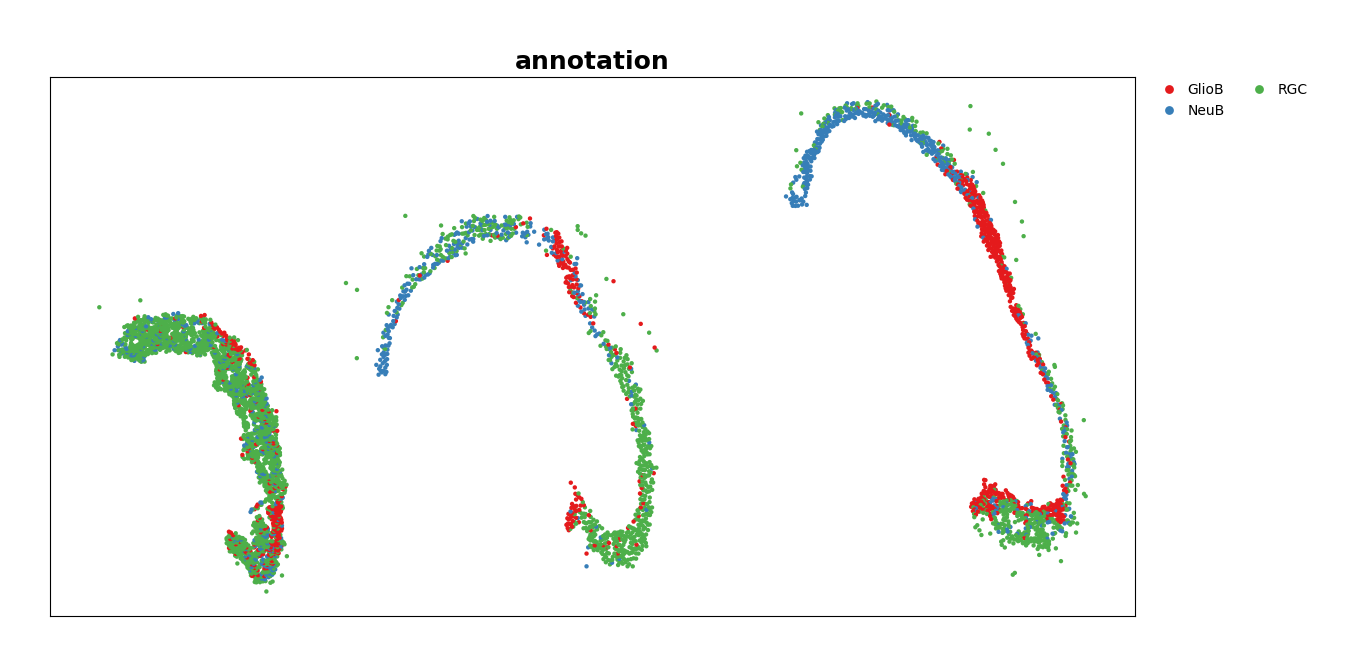

In [4]:
data.plt.cluster_scatter(res_key='annotation', width=1400, height=700, marker='o', dot_size=10, show_plotting_scale=False, invert_y=False)

## Calculate transition probability across sections

### Create a multi-sample data structure

Create a multi-sample data structure along the time points specified by obs-key **Time point**, in this case, the data will be split into 3 single samples with 3 different **Time point**.

In [5]:
ms_data = MSData.to_msdata(data, batch_key='Time point')
ms_data

ms_data: {'E12.5': (2237, 24045), 'E14.5': (953, 24045), 'E16.5': (1338, 24045)}
num_slice: 3
names: ['E12.5', 'E14.5', 'E16.5']
merged_data: None
obs: []
var: []
relationship: other
var_type: intersect to 0
current_mode: integrate
current_scope: scope_[0,1,2]
scopes_data: []
mss: []

### Get An object of spaTrack

In [6]:
spt = ms_data.tl.ms_spa_track(cluster_res_key='annotation')

2024-11-07 10:05:26.178946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Calculate transition probability

spaTrack infers cell tracing across multiple ST sections based on an unbalanced and structured optimal transport algorithm. We can calculate the transfer matrix between two ST sections using the `spt.transfer_matrix` function. Additionally, the transition probability between two sections can be calculated using `spt.map_data`. To obtain complete results across multiple sections, `spt.generate_animate_input` is used to integrate the transition probability results.

In [7]:
spt.transfer_matrix(data1_index='E12.5', data2_index='E14.5', epsilon=0.01, alpha=0.5)
spt.transfer_matrix(data1_index='E14.5', data2_index='E16.5', epsilon=0.01, alpha=0.5)

We also can obtain the result containing cell transition probability among three ST sections.

In [8]:
spt.generate_animate_input(data_indices=['E12.5', 'E14.5', 'E16.5'], time_key='Time point')

In [9]:
ms_data.tl.result['spa_track']['transfer_data'].head()

,slice1,slice2,slice3,slice1_annotation,slice2_annotation,slice3_annotation,slice1_x,slice2_x,slice3_x,slice1_y,slice2_y,slice3_y,k_line_12,b_line_12,k_line_23,b_line_23,pi_value1,pi_value2
0,CELL.100034_1,CELL.174282_3,CELL.6090_2,RGC,GlioB,RGC,2829.0,7709.0,14163.004072,-10000.0,-9508.0,-9438.505655,0.100820,-10285.218852,0.010768,-9591.007680,0.000043,0.000118
1,CELL.105423_1,CELL.174282_3,CELL.6090_2,NeuB,GlioB,RGC,2325.0,7709.0,14163.004072,-9678.5,-9508.0,-9438.505655,0.031668,-9752.127879,0.010768,-9591.007680,0.000076,0.000118
2,CELL.100795_1,CELL.174235_3,CELL.5906_2,RGC,RGC,GlioB,2893.0,8825.0,15324.653342,-9946.5,-9519.0,-9458.827390,0.072067,-10154.989127,0.009258,-9600.700247,0.000055,0.000075
3,CELL.105209_1,CELL.174235_3,CELL.5906_2,GlioB,RGC,GlioB,3007.0,8825.0,15324.653342,-9693.0,-9519.0,-9458.827390,0.029907,-9782.930904,0.009258,-9600.700247,0.000046,0.000075
4,CELL.114403_1,CELL.174235_3,CELL.5906_2,RGC,RGC,GlioB,2856.0,8825.0,15324.653342,-8887.5,-9519.0,-9458.827390,-0.105797,-8585.344865,0.009258,-9600.700247,0.000065,0.000075


The **transfer_data** above contains comprehensive results from multiple sections. In the dataframe, First three columns represent the CellID in slice1, slice2, and slice3 with the maximum transition probability among them. The pi_value1 represents the maximum transition probability value between the CellID in slice1 and slice2. Similarly, the pi_value2 represents the maximum transition probability value between the CellID in slice2 and slice3. The k_line and b_line represent slopes and intercepts of lines connecting two cells used by spt.animate_transfer() function to display dynamic figure. Users have the option to filter the maximum transition probability values based on their distribution.

## Visualze cell transfer by dynamic figure

In [ ]:
spt.plot.animate_transfer(
    data_indices=['E12.5', 'E14.5', 'E16.5'],
    time_key ='Time point',
    save_path='./cell.transfer.animation.html',
)

![alt text](../_static/230906.gif)

## Visualize cell transfer by 3D figure

We can visualize the three sections and the line cells with the maximum transition probability in a 3D space.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

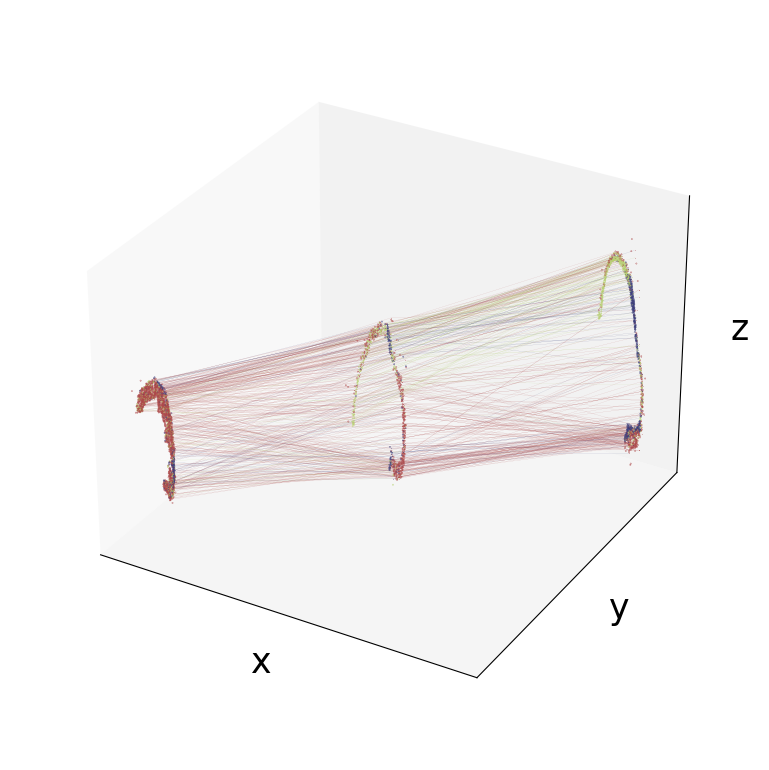

In [11]:
spt.plot.visual_3D_mapping_3(
    data_indices=['E12.5', 'E14.5', 'E16.5'],
    dot_size=0.8,
    line_width=0.06
)

We can visualize specific two consecutive sections after calculating the transition probability across the sections. Now,we can obtain the file containing cell transition probability between section 1(**E14.5**) and section 2(**E16.5**).

In [12]:
spt.map_data(data1_index='E14.5', data2_index='E16.5')

,slice1,slice2,pi_value
CELL.171967_3,CELL.171967_3,CELL.6438_2,0.000142
CELL.172008_3,CELL.172008_3,CELL.5694_2,0.000125
CELL.172028_3,CELL.172028_3,CELL.6242_2,0.000059
CELL.172036_3,CELL.172036_3,CELL.5934_2,0.000101
CELL.172085_3,CELL.172085_3,CELL.5836_2,0.000115
...,...,...,...
CELL.180529_3,CELL.180529_3,CELL.1796_2,0.000086
CELL.180537_3,CELL.180537_3,CELL.3207_2,0.000107
CELL.180539_3,CELL.180539_3,CELL.3044_2,0.000118
CELL.180540_3,CELL.180540_3,CELL.3688_2,0.000079


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

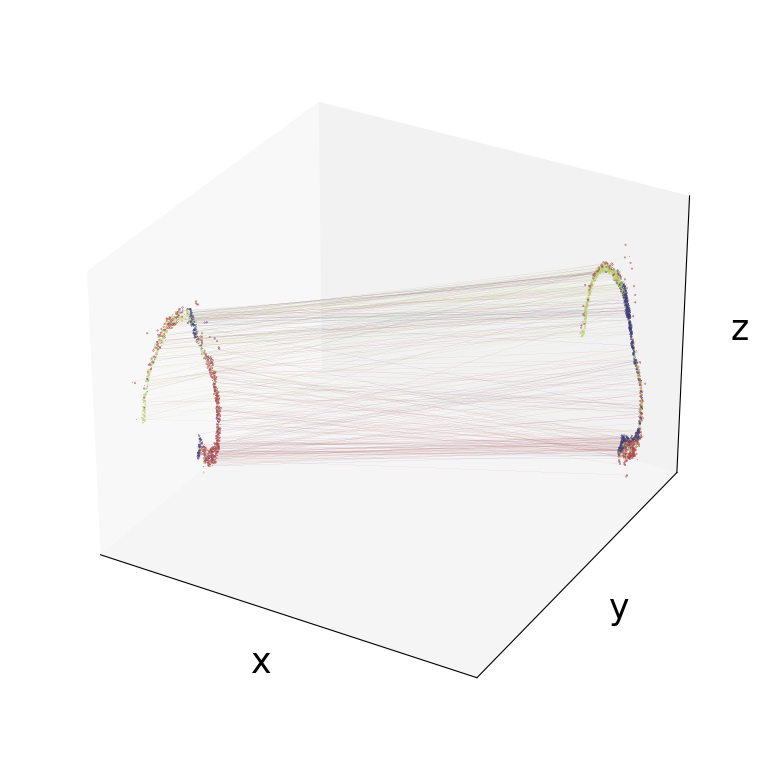

In [13]:
spt.plot.visual_3D_mapping_2(
    data1_index='E14.5',
    data2_index='E16.5',
    dot_size=1,
    line_width=0.05
)

## Construct gene regulation network

Here, we use data from **E12.5** and **E14.5** as an example to construct regulatory network between TF genes and target genes inferred along the developmental trajectory between two time points.TF genes list of Mouse and Human can be download from [the link](http://116.6.21.110:8090/share/3ca60300-e8bd-4d67-8b68-14267e428523).

In [14]:
gr = spt.gr_training(
    data1_index='E12.5',
    data2_index='E14.5',
    tfs_path='../spaTrack/spaTrack/example.data/ms.TF.tsv',
    min_cells_1=50,         #recommend maintaining gene expression in ～ 3% of cells.
    min_cells_2=20,
    cell_generate_per_time=10000,
    cell_select_per_time=50,
    training_times=10,
    iter_times=30
)

Train 10: 100%|██████████| 300/300 [03:33<00:00,  1.41it/s, train_loss=0.0144, test_loss=0.0158]
[2024-11-07 10:10:25][Stereo][1068][MainThread][140492234536768][gene_regulation][292][INFO]: Weight relationships of tfs and genes are stored in weights.csv.


Show the relationship between TF and target genes by scatter diagram.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

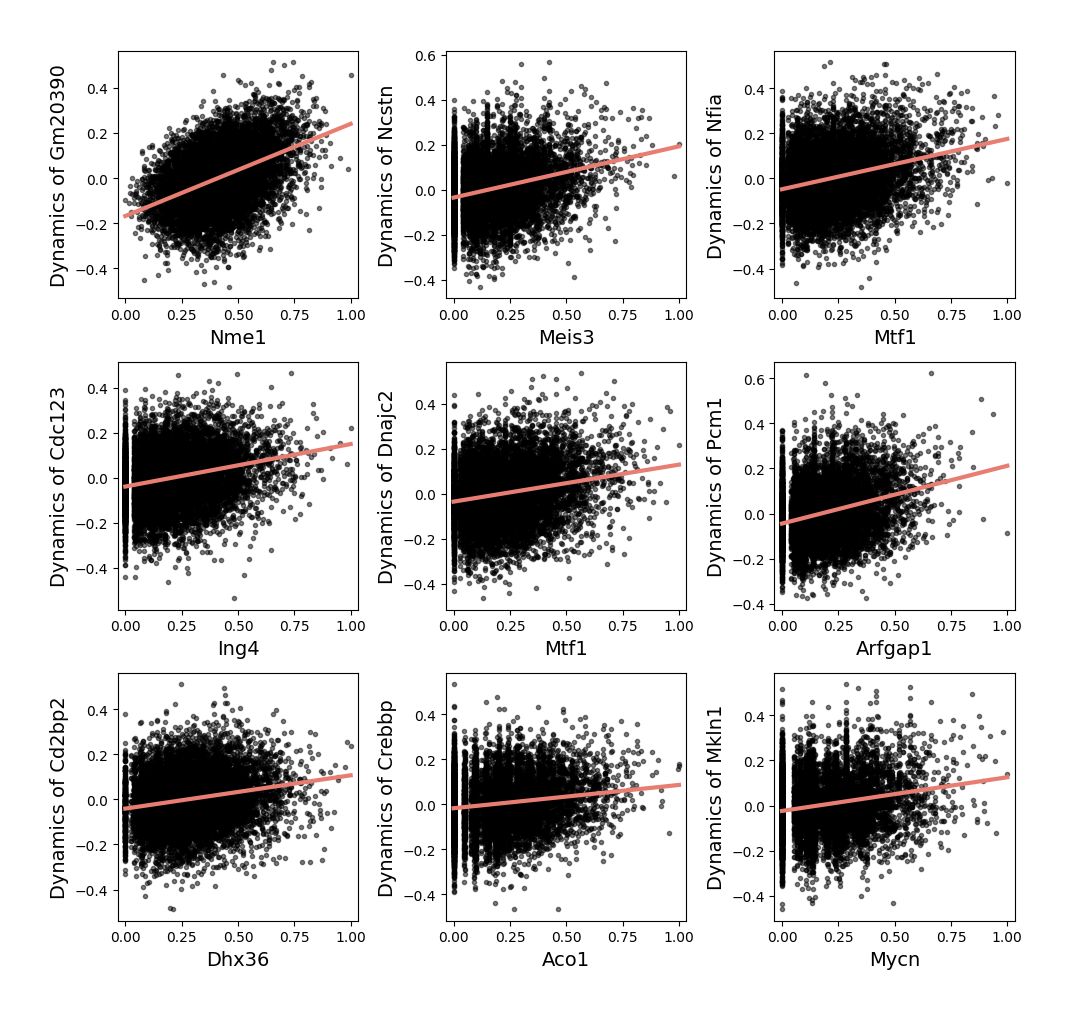

In [15]:
gr.plot_scatter()

Get weights between TFs and genes.

In [16]:
gr.network_df

,TF,gene,weight
347,Nme1,Gm20390,0.031272
950,Meis3,Ncstn,0.021513
1197,Mtf1,Nfia,0.021020
2294,Ing4,Cdc123,0.020342
1785,Mtf1,Dnajc2,0.020236
...,...,...,...
1630,Chd1,Foxk2,0.010869
435,Creb1,Cnot8,0.010869
2862,Chd1,Kdm2a,0.010868
694,Srebf1,Vps4b,0.010868


Plot the gene regulatory network diagram according to the `gr.network_df`.

num of weight pairs after weight filtering: 1388
num of weight pairs after node_count filtering: 394


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

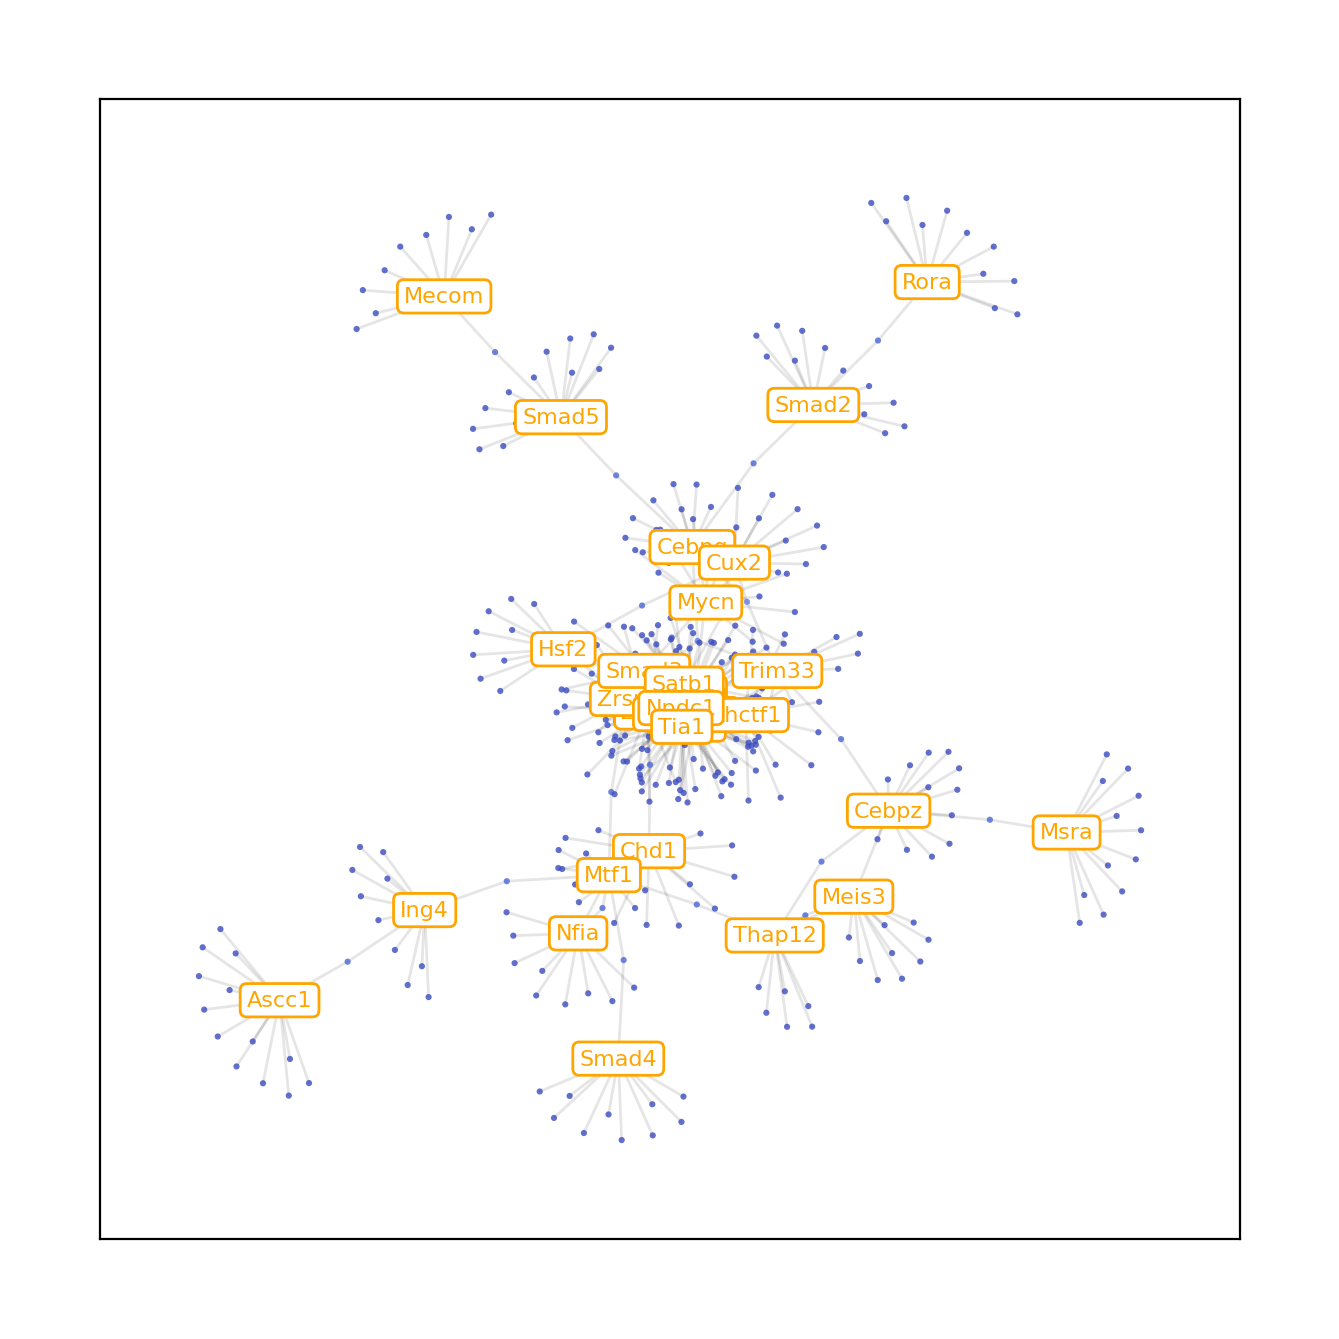

In [17]:
gr.plot_gene_regulation(min_weight=0.012, min_node_num=10)